In [591]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

In [592]:
x_train = pd.read_csv('./global_data/x_train.csv')
y_train = pd.read_csv('./global_data/y_train.csv')
x_test = pd.read_csv('./global_data/x_test.csv')

In [593]:
x_train_fr = x_train[x_train['COUNTRY'] == 'FR'].drop('COUNTRY', axis=1).fillna(0)
y_train_fr = y_train.merge(x_train_fr)['TARGET'].fillna(0)
x_train_de = x_train[x_train['COUNTRY'] == 'DE'].drop('COUNTRY', axis=1).fillna(0)
y_train_de = y_train.merge(x_train_de)['TARGET'].fillna(0)

In [594]:
def getLR(x, y): 
    total = 0
    loops = 300

    for i in range(loops): 
        xTr, xTe, yTr, yTe = train_test_split(x, y, test_size=0.2, random_state=i) 

        lr = LinearRegression()
        lr.fit(xTr, yTr)
        total = total + 100 * spearmanr(lr.predict(xTe), yTe).correlation
    
    return (total / loops)

In [595]:
def getBestAttributeLR(data, x, prev_corr, y):
    cols = data.columns.tolist()
    corr = 0
    feature = None

    for col in cols:
        x[col] = data[col]
        temp_corr = getLR(x, y)
        
        if temp_corr > corr:
            corr = temp_corr
            feature = col
        else:
            x = x.drop(col, axis=1)

    if corr < prev_corr or len(cols) == 1 or feature == None:
        return x 
    else:
        data = data.drop(feature, axis=1)
        return getBestAttributeLR(data, x, corr, y)


In [596]:
empty_fr = pd.DataFrame() 
empty_fr['ID'] = x_train_fr['ID']
optimum_fr = getBestAttributeLR(x_train_fr, empty_fr, 0, y_train_fr)

In [597]:
optimum_fr

,DE_NET_EXPORT,DE_HYDRO,CARBON_RET,ID
0,0.000000,2.209047,-0.002445,1054
1,-0.573520,0.187964,-0.490365,2049
2,-0.622021,-0.108578,0.204952,1924
4,0.000000,-0.230179,2.614378,1101
5,-1.117139,2.306980,1.124457,1520
...,...,...,...,...
1483,-0.977214,1.781299,1.322433,1776
1486,1.403843,-0.385397,1.472650,1401
1487,0.101161,-0.315249,0.606318,1728
1490,0.449153,-0.341147,0.356356,1674


In [598]:
getLR(optimum_fr, y_train_fr)

15.64635502501608

In [599]:
empty_de = pd.DataFrame() 
empty_de['ID'] = x_train_de['ID']
optimum_de = getBestAttributeLR(x_train_de, empty_de, 0, y_train_de)

In [600]:
optimum_de

,FR_CONSUMPTION,DE_SOLAR,DE_FR_EXCHANGE,FR_NUCLEAR,ID,DE_HYDRO,FR_DE_EXCHANGE,DE_CONSUMPTION,DE_NET_EXPORT,FR_GAS,FR_COAL
3,-0.849198,1.751523,-0.839586,-1.589554,297,-0.368417,0.839586,-0.983324,-0.270870,0.194659,-0.786025
11,-0.811337,1.172155,0.237105,-1.838556,819,1.282374,-0.237105,-0.055692,-0.851082,-0.145637,-0.770846
12,-0.331101,-0.324789,0.339942,-1.719257,918,-0.168264,-0.339942,0.532116,-0.173123,1.382599,-0.753365
13,-1.062255,0.509242,-1.380464,-1.200788,283,0.523610,1.380464,-0.328286,-1.046122,-0.730992,-0.455367
14,1.629315,-1.234093,1.129663,-0.277100,158,1.223032,-1.129663,1.028987,-0.391261,2.122272,0.857983
...,...,...,...,...,...,...,...,...,...,...,...
1485,-0.235078,-0.394101,0.962203,-0.555283,391,0.128621,-0.962203,0.810509,0.971934,0.219593,-0.132530
1488,-1.051247,0.344296,-1.651718,-1.289413,342,2.053830,1.651718,-0.295522,-1.969871,0.076716,-0.781673
1489,1.106682,-1.325306,-1.855327,0.712492,459,-0.470809,1.855327,1.529204,-0.218658,1.388269,-0.294001
1491,0.489199,-0.626731,-0.255778,-0.964588,748,0.037892,0.255778,0.856399,-1.531544,1.866399,-0.180117


In [601]:
getLR(optimum_de, y_train_de)

38.67580056415262

In [602]:
lr_fr = LinearRegression()
lr_fr.fit(optimum_fr, y_train_fr)
lr_de = LinearRegression()
lr_de.fit(optimum_de, y_train_de)

LinearRegression()

In [603]:
fr_cols = optimum_fr.columns
de_cols = optimum_de.columns

In [604]:
x_test_fr = x_test[x_test['COUNTRY'] == 'FR'].drop('COUNTRY', axis=1).fillna(0)[fr_cols]
x_test_de = x_test[x_test['COUNTRY'] == 'DE'].drop('COUNTRY', axis=1).fillna(0)[de_cols]

y_pred_de = lr_de.predict(x_test_de)
y_pred_fr = lr_fr.predict(x_test_fr)

y_de = pd.DataFrame()
y_de['ID'] = x_test_de['ID']
y_de['TARGET'] = y_pred_de

y_fr = pd.DataFrame()
y_fr['ID'] = x_test_fr['ID']
y_fr['TARGET'] = y_pred_fr

y_pred = pd.concat([y_fr, y_de])

In [605]:
y_csv = y_pred.to_csv('WACC35_Submission1.csv')

In [606]:
def test_local(fr_model, de_model):
    total = 0
    result = 0
    loops = 1000

    for i in range(loops):
        xTr, xTe, yTr, yTe = train_test_split(x_train, y_train, test_size=0.2, random_state=i) 

        x_test_fr = xTe[xTe['COUNTRY'] == 'FR'].drop('COUNTRY', axis=1).fillna(0)[fr_cols]
        x_test_de = xTe[xTe['COUNTRY'] == 'DE'].drop('COUNTRY', axis=1).fillna(0)[de_cols]

        y_pred_de = de_model.predict(x_test_de)
        y_pred_fr = fr_model.predict(x_test_fr)

        y_de = pd.DataFrame()
        y_de['ID'] = x_test_de['ID']
        y_de['TARGET'] = y_pred_de

        y_fr = pd.DataFrame()
        y_fr['ID'] = x_test_fr['ID']
        y_fr['TARGET'] = y_pred_fr

        y_pred = pd.concat([y_fr, y_de])

        y_pred = y_pred.sort_values(ascending=True, by='ID')
        yTe = yTe.sort_values(ascending=True, by='ID')
        spearman = (100 * spearmanr(y_pred['TARGET'], yTe['TARGET']).correlation)
        total = total + spearman

    result = total / loops
    return result

In [607]:
test_local(lr_fr, lr_de)

32.798683045902614

In [608]:
pls_fr = PLSRegression

In [618]:
merged_df = pd.concat([x_train, y_train], axis = 1)
merged_df.columns

Index(['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'ID', 'TARGET'],
      dtype='object')

In [619]:
merged_df

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,ID,TARGET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,1054,0.028313
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,2049,-0.112516
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,1924,-0.180840
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,297,-0.260356
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,1101,-0.071733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459,809,DE,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,...,NaN,NaN,NaN,NaN,NaN,0.876984,0.819520,1.320373,459,-0.172597
1490,1674,887,FR,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,...,NaN,NaN,NaN,NaN,NaN,0.932633,-0.085690,0.356356,1674,-0.063546
1491,748,1083,DE,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,...,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152,748,0.151797
1492,1454,1133,FR,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,...,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812,1454,-0.640917


In [628]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

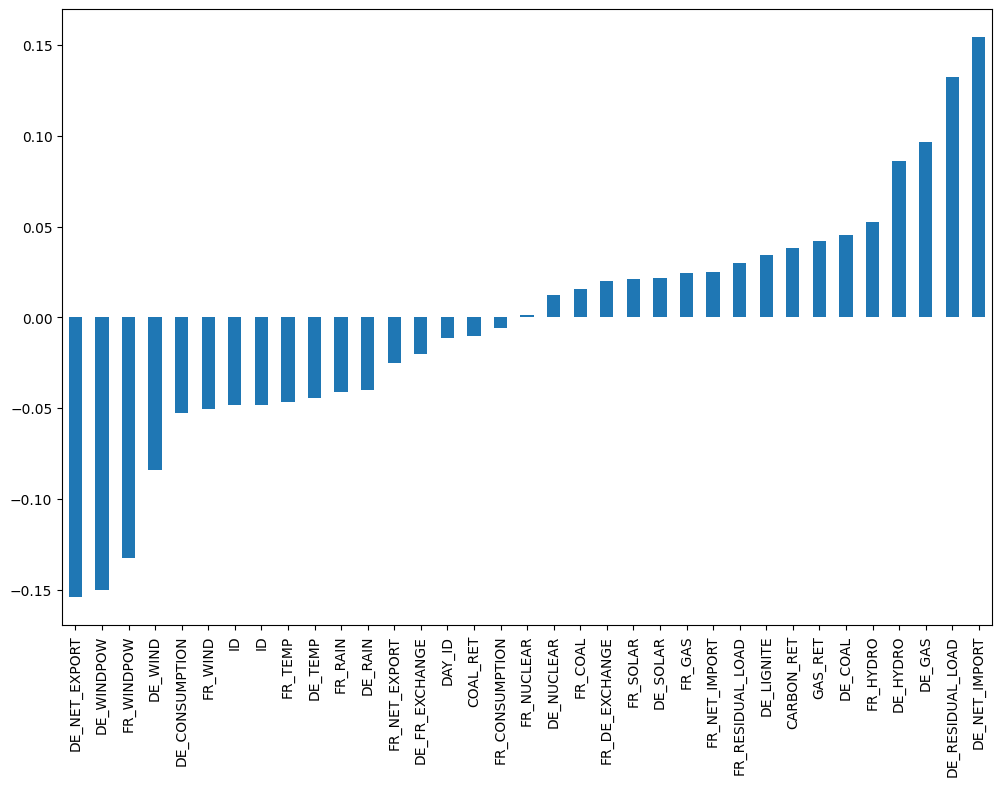

In [623]:
plt.figure(figsize = (12,8))
merged_df.drop('COUNTRY', axis = 1).corr()['TARGET'][:-1].sort_values().plot(kind = 'bar')

<Axes: >

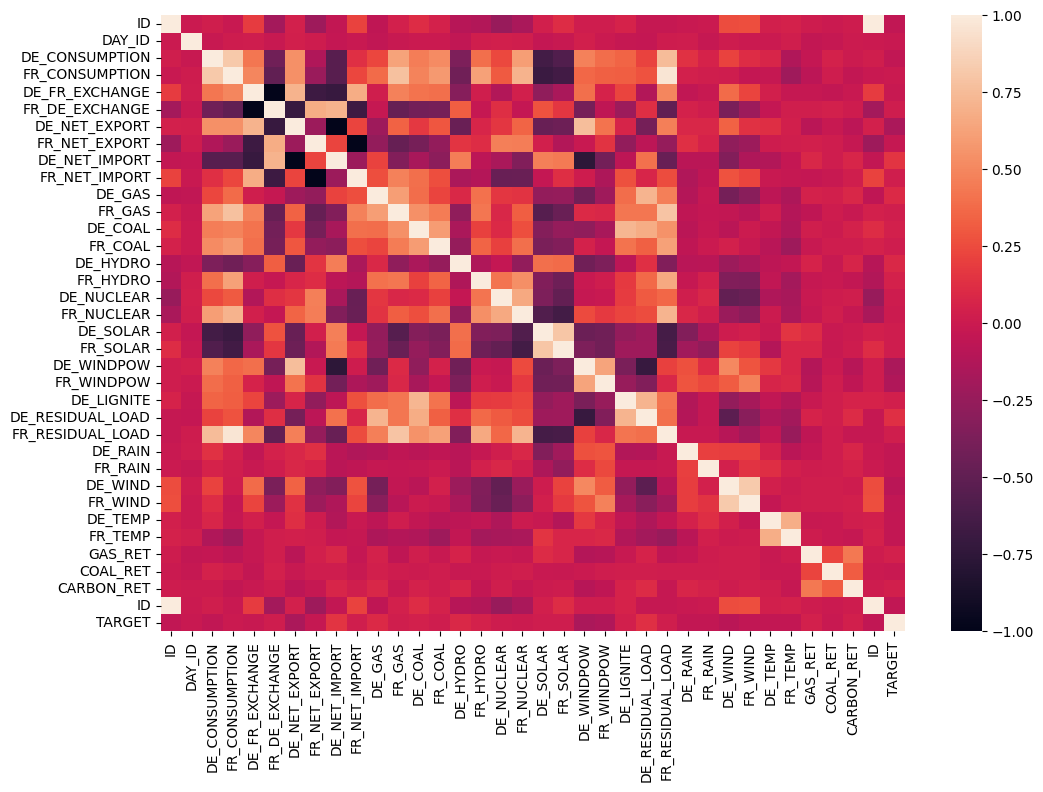

In [630]:
plt.figure(figsize = (12,8))

sns.heatmap(merged_df.drop('COUNTRY', axis = 1).corr())

In [631]:
merged_df[['DE_RESIDUAL_LOAD', 'DE_WIND']].corr()

,DE_RESIDUAL_LOAD,DE_WIND
DE_RESIDUAL_LOAD,1.000000,-0.517124
DE_WIND,-0.517124,1.000000


<Axes: >

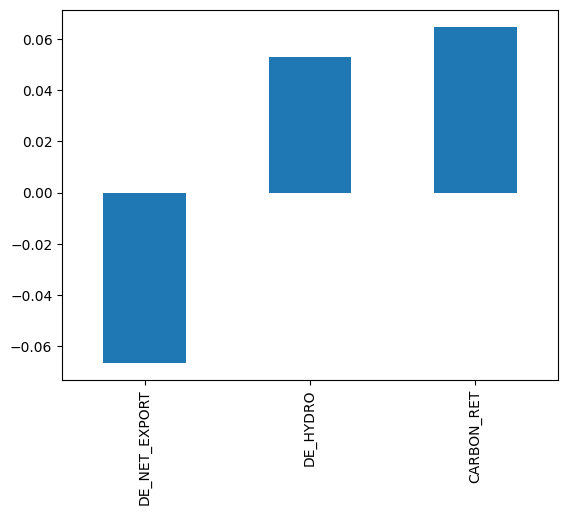

In [642]:
merged_opt_fr = optimum_fr.merge(y_train)
merged_opt_fr.drop('ID', axis = 1).corr()['TARGET'][:-1].sort_values().plot(kind = 'bar')

<Axes: xlabel='TARGET', ylabel='FR_CONSUMPTION'>

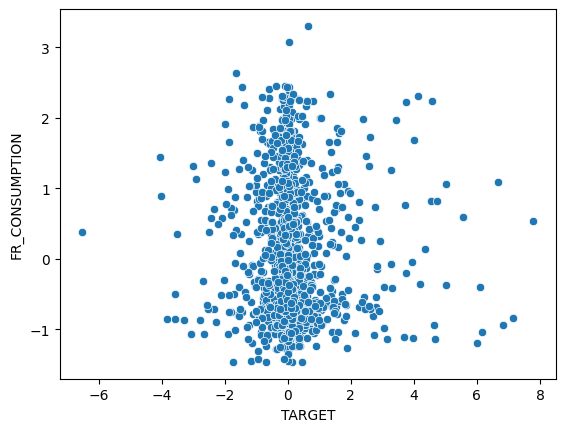

In [643]:
sns.scatterplot(data = merged_df, x = 'TARGET', y ='FR_CONSUMPTION')

# Shows standardised data